In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import math
import seaborn as sns
import sklearn
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
%matplotlib inline
sns.set_style('white')
pd.options.display.float_format = '{:.3f}'.format

import time
from sklearn.model_selection import train_test_split
from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error

# Final Capstone
## Predicting Taxi Fares in New York City
   My final capstone will work to predict taxi fare prices throughout New York City using data that includes GPS coordinates from pickup and dropoff locations, fare prices of each ride, and the number of riders of each ride. This would be useful for taxi fare companies who seek to stay competitive with rideshare companies like Uber and Lyft. Examination of the data will allow for insight into the time of day where taxi cabs are most used allowing for the deploying of the optimal amount of taxi drivers. Popular drop off/pick up points could be examined to provide more space at heavily trafficked drop off zones.

The data was obtained using the NYC Taxi Data API. The dataset is rather large with over 55 million rows of data. The dataset contains rides between 2009 and 2015. Sample data by a percentage 

Figure out congestion time split dummy variables
12-4
4-8
8-12
12-4
8-12

Possible research Questions

- What kind of information can we obtain from clustering?
- What machine learning technique is best 

In [2]:
#taxi_test_data = pd.read_csv(r'C:\\Users\\david\Final Capstone\\NYC Taxi Data\\test.csv')
taxi_train_data = pd.read_csv(r'C:\\Users\\david\Final Capstone\\NYC Taxi Data\\train.csv', nrows = 2_750_000)

#using 5% of the data
#C:\Users\david\Final Capstone\NYC Taxi Data

In [3]:
null_count = taxi_train_data.isnull().sum()
null_count[null_count>0]

dropoff_longitude    22
dropoff_latitude     22
dtype: int64

In [4]:
taxi_train_data = taxi_train_data.dropna(how ='any', axis = 'rows')

In [5]:
taxi_train_data = taxi_train_data.drop(['key'], axis=1)

In [6]:
taxi_train_data.shape

(2749978, 7)

In [7]:
taxi_train_data.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,2749978.000,2749978.000,2749978.000,2749978.000,2749978.000,2749978.000
mean,11.340,-72.517,39.926,-72.517,39.921,1.684
std,9.828,13.153,8.513,12.808,10.155,1.325
min,-62.000,-3426.609,-3488.080,-3408.430,-3488.080,0.000
25%,6.000,-73.992,40.735,-73.991,40.734,1.000
50%,8.500,-73.982,40.753,-73.980,40.753,1.000
75%,12.500,-73.967,40.767,-73.964,40.768,2.000
max,1273.310,3439.426,2912.465,3414.307,3345.917,208.000


It looks like there are some extreme outliers in the case of latitude and longitude. Let's bound everything so it includes datapoints that are within New York City. The min is about -74 for longitude and about 41 for latitude. Let's create a function that adds 5 degrees. 

https://www.mapdevelopers.com/geocode_bounding_box.php

In [8]:
-74.5, -72.8, 40.5, 41.8

def clean_df(taxi_train_data):
    return taxi_train_data[(taxi_train_data.pickup_longitude > -74.259090) & (taxi_train_data.pickup_longitude < -73.70072) &
        (taxi_train_data.pickup_latitude > 40.477399 ) & (taxi_train_data.pickup_latitude < 40.917577) &
        (taxi_train_data.dropoff_longitude > -74.259090) & (taxi_train_data.dropoff_longitude < -73.70072) &
        (taxi_train_data.dropoff_latitude > 40.477399 ) & (taxi_train_data.dropoff_latitude < 40.917577) &
        (taxi_train_data.passenger_count > 0) & (taxi_train_data.passenger_count < 7)] 

taxi_train_data = clean_df(taxi_train_data)
print(len(taxi_train_data))

2679313


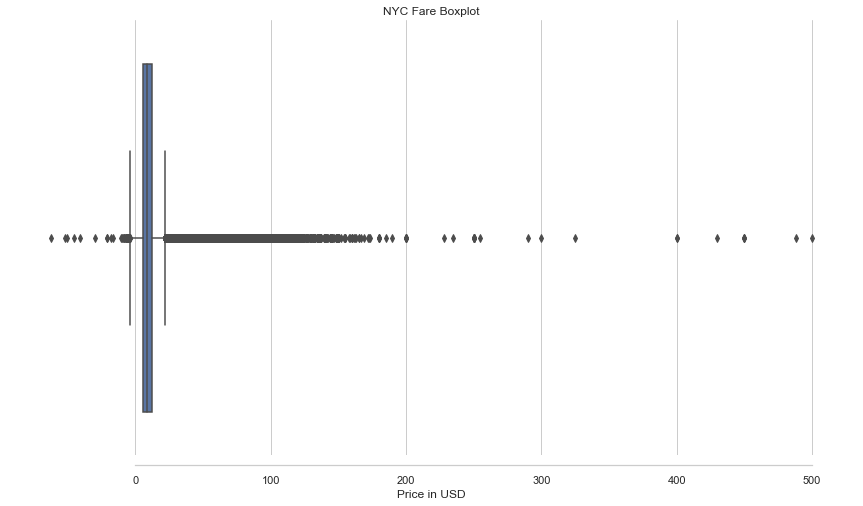

In [9]:
plt.figure(figsize=(15, 8))
sns.set(style="whitegrid")

ax = sns.boxplot(x=taxi_train_data['fare_amount'])  

plt.title('NYC Fare Boxplot')

sns.despine(offset=10, trim=True)
ax.set(xlabel='Price in USD', ylabel='')

plt.show()

The fare data also has some extreme outliers with the max being a little over $ 1,200. Also, it seems that there were some negative fares where people were paid to ride in the taxis? Let's remove those and bound it to $ 2.50 and $ 100. $ 2.50 is the minimum cab fare in NYC

In [10]:
#fix the fare outliers
taxi_train_data = taxi_train_data[taxi_train_data['fare_amount'].between(left = 2.5, right = 100)]

In [11]:
taxi_train_data.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,2678671.000,2678671.000,2678671.000,2678671.000,2678671.000,2678671.000
mean,11.269,-73.976,40.751,-73.975,40.751,1.690
std,9.317,0.034,0.027,0.034,0.031,1.306
min,2.500,-74.259,40.483,-74.259,40.478,1.000
25%,6.000,-73.992,40.737,-73.992,40.736,1.000
50%,8.500,-73.982,40.753,-73.981,40.754,1.000
75%,12.500,-73.968,40.767,-73.965,40.768,2.000
max,100.000,-73.701,40.917,-73.701,40.918,6.000


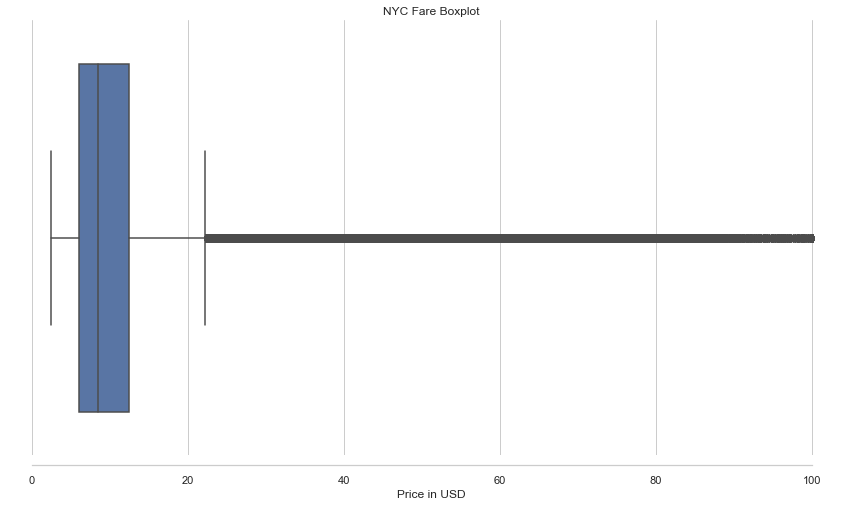

In [12]:
plt.figure(figsize=(15, 8))
sns.set(style="whitegrid")

ax = sns.boxplot(x=taxi_train_data['fare_amount'])  

plt.title('NYC Fare Boxplot')

sns.despine(offset=10, trim=True)
ax.set(xlabel='Price in USD', ylabel='')

plt.show()

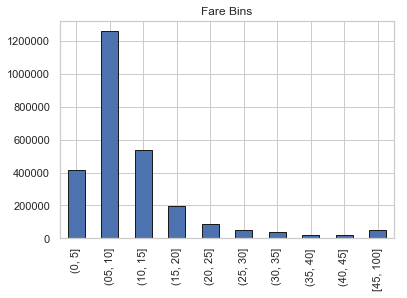

In [13]:
# Bin the fare and convert to string
taxi_train_data['fare-bin'] = pd.cut(taxi_train_data['fare_amount'], bins = list(range(0, 50, 5))).astype(str)

# Uppermost bin
taxi_train_data.loc[taxi_train_data['fare-bin'] == 'nan', 'fare-bin'] = '[45, 100]'

# Adjust bin so the sorting is correct
taxi_train_data.loc[taxi_train_data['fare-bin'] == '(5, 10]', 'fare-bin'] = '(05, 10]'

# Bar plot of value counts
taxi_train_data['fare-bin'].value_counts().sort_index().plot.bar(color = 'b', edgecolor = 'k');
plt.title('Fare Bins');

In [14]:
taxi_train_data = taxi_train_data.drop(['fare-bin'], axis=1)

In [15]:
taxi_train_data.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,2678671.000,2678671.000,2678671.000,2678671.000,2678671.000,2678671.000
mean,11.269,-73.976,40.751,-73.975,40.751,1.690
std,9.317,0.034,0.027,0.034,0.031,1.306
min,2.500,-74.259,40.483,-74.259,40.478,1.000
25%,6.000,-73.992,40.737,-73.992,40.736,1.000
50%,8.500,-73.982,40.753,-73.981,40.754,1.000
75%,12.500,-73.968,40.767,-73.965,40.768,2.000
max,100.000,-73.701,40.917,-73.701,40.918,6.000


## Feature Engineering
#### Time and Date Features
Creating columns for:
- Year
- Month
- Day
- Hour
- Day of the Week

#### Distance Feature
Distance:
- Distance from pickup and dropoff locations

In [16]:
"""def morning_rush (row):
    if (row['hour'] <= 9) and (row['hour'] >= 6) and (row['weekday'] < 5):
        return 1
    else:
        return 0"""
"""
def mid_day (row):
    if (row['hour'] <= 15) and (row['hour'] >= 10):
        return 1
    else:
        return 0 
    
def late_night (row):
    if (row['hour'] <= 5) or (row['hour'] >= 20):
        return 1
    else:
        return 0    
    
    
def night_rush (row):
    if ((row['hour'] <= 20) and (row['hour'] >= 15)) and (row['weekday'] < 5):
        return 1
    else:
        return 0"""

def add_time_features(taxi_train_data):
    taxi_train_data['pickup_datetime'] =  pd.to_datetime(taxi_train_data['pickup_datetime'], format='%Y-%m-%d %H:%M:%S %Z')
    taxi_train_data['year'] = taxi_train_data['pickup_datetime'].apply(lambda x: x.year)
    taxi_train_data['month'] = taxi_train_data['pickup_datetime'].apply(lambda x: x.month)
    taxi_train_data['day'] = taxi_train_data['pickup_datetime'].apply(lambda x: x.day)
    taxi_train_data['hour'] = taxi_train_data['pickup_datetime'].apply(lambda x: x.hour)
    taxi_train_data['weekday'] = taxi_train_data['pickup_datetime'].apply(lambda x: x.weekday())
    #taxi_train_data['pickup_datetime'] =  taxi_train_data['pickup_datetime'].apply(lambda x: str(x))

    taxi_train_data = taxi_train_data.drop('pickup_datetime', axis=1)
    
    return taxi_train_data

def add_coordinate_features(taxi_train_data):
    lat1 = taxi_train_data['pickup_latitude']
    lat2 = taxi_train_data['dropoff_latitude']
    lon1 = taxi_train_data['pickup_longitude']
    lon2 = taxi_train_data['dropoff_longitude']
    
    # Add new features
    taxi_train_data['latdiff'] = (lat1 - lat2)
    taxi_train_data['londiff'] = (lon1 - lon2)

    return taxi_train_data


def add_distances_features(taxi_train_data):

    lat1 = taxi_train_data['pickup_latitude']
    lat2 = taxi_train_data['dropoff_latitude']
    lon1 = taxi_train_data['pickup_longitude']
    lon2 = taxi_train_data['dropoff_longitude']
    
    taxi_train_data['distance_traveled'] = (taxi_train_data['latdiff'] ** 2 + taxi_train_data['londiff'] ** 2) ** 0.5
    
    return taxi_train_data


In [17]:

taxi_train_data = add_time_features(taxi_train_data)
#taxi_train_data = add_time_features(taxi_train_data)

add_coordinate_features(taxi_train_data)
#add_coordinate_features(taxi_train_data)

taxi_train_data = add_distances_features(taxi_train_data)
#taxi_train_data = add_distances_features(taxi_train_data)

taxi_train_data.head(5)

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,hour,weekday,latdiff,londiff,distance_traveled
0,4.500,-73.844,40.721,-73.842,40.712,1,2009,6,15,17,0,0.009,-0.003,0.009
1,16.900,-74.016,40.711,-73.979,40.782,1,2010,1,5,16,1,-0.071,-0.037,0.080
2,5.700,-73.983,40.761,-73.991,40.751,2,2011,8,18,0,3,0.011,0.009,0.014
3,7.700,-73.987,40.733,-73.992,40.758,1,2012,4,21,4,5,-0.025,0.004,0.025
4,5.300,-73.968,40.768,-73.957,40.784,1,2010,3,9,7,1,-0.016,-0.011,0.019


In [18]:
taxi_train_data.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,hour,weekday,latdiff,londiff,distance_traveled
0,4.500,-73.844,40.721,-73.842,40.712,1,2009,6,15,17,0,0.009,-0.003,0.009
1,16.900,-74.016,40.711,-73.979,40.782,1,2010,1,5,16,1,-0.071,-0.037,0.080
2,5.700,-73.983,40.761,-73.991,40.751,2,2011,8,18,0,3,0.011,0.009,0.014
3,7.700,-73.987,40.733,-73.992,40.758,1,2012,4,21,4,5,-0.025,0.004,0.025
4,5.300,-73.968,40.768,-73.957,40.784,1,2010,3,9,7,1,-0.016,-0.011,0.019


## Taxi Cab Ride Frequency by hour

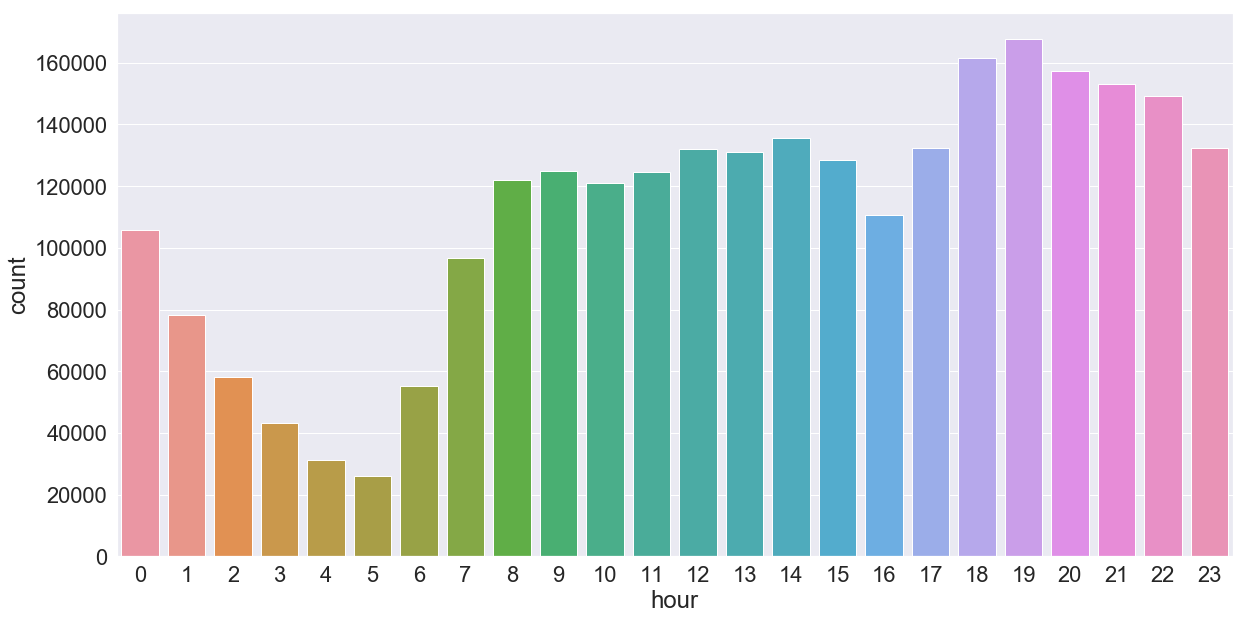

In [19]:
plt.figure(figsize=(20, 10))
n_freq=taxi_train_data['hour'].value_counts()
n_freq

n_df = pd.DataFrame({'hour':n_freq.index ,'count':n_freq.values})
n_df

sns.set(font_scale =2)

sns.barplot(x='hour', y='count', data=n_df, label = "medium")


## Taxi Cab Ride Frequency by Month

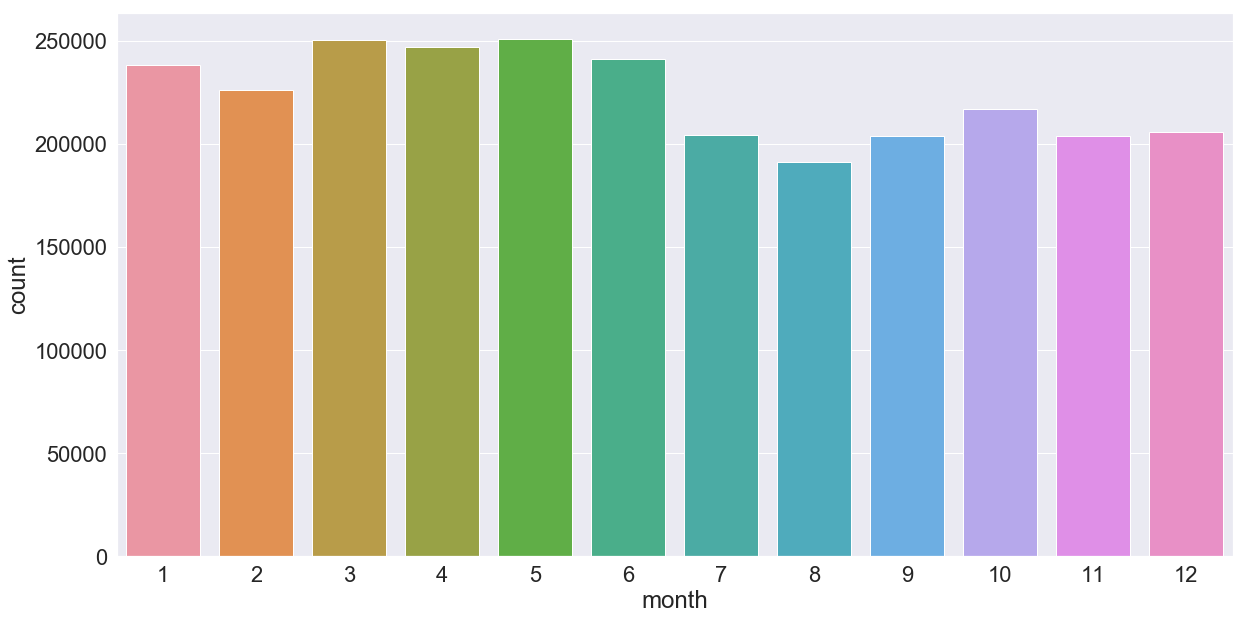

In [20]:
plt.figure(figsize=(20, 10))
n_freq=taxi_train_data['month'].value_counts()
n_freq

n_month = pd.DataFrame({'month':n_freq.index ,'count':n_freq.values})
n_month

sns.set(font_scale =2)

sns.barplot(x='month', y='count', data=n_month, label= "medium")


## Taxi Cab Ride Frequency by Day of Week

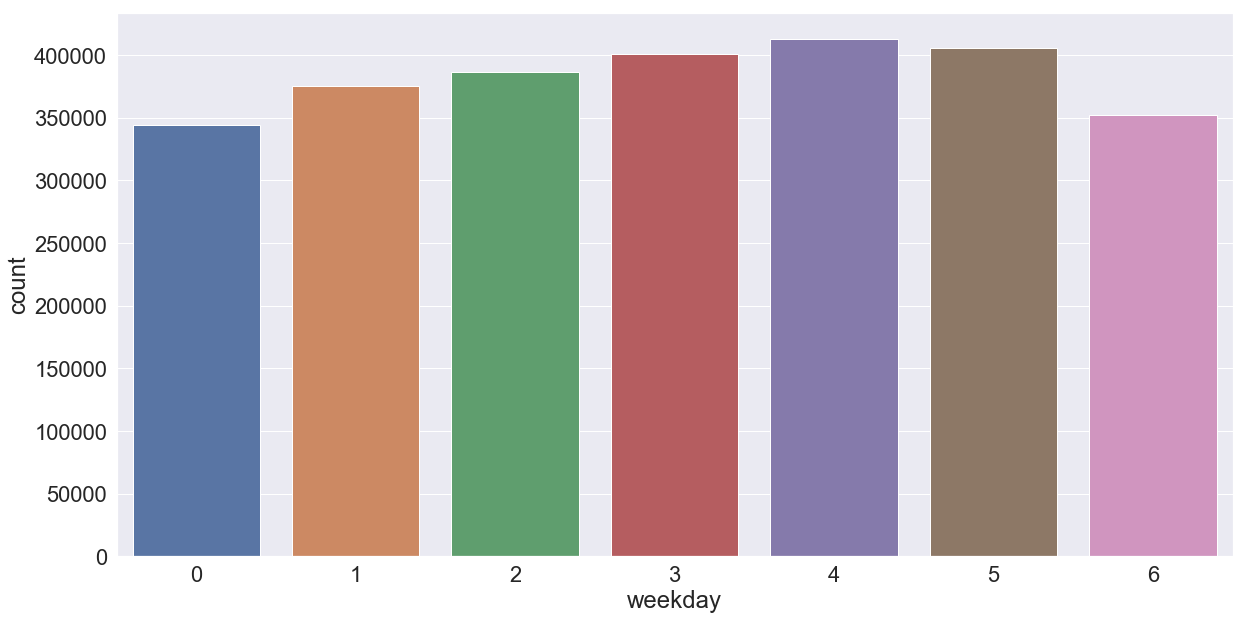

In [21]:
plt.figure(figsize=(20, 10))
n_freq=taxi_train_data['weekday'].value_counts()
n_freq

n_weekday = pd.DataFrame({'weekday':n_freq.index ,'count':n_freq.values})
n_weekday

sns.set(font_scale =2)

sns.barplot(x='weekday', y='count', data=n_weekday, label = "medium")


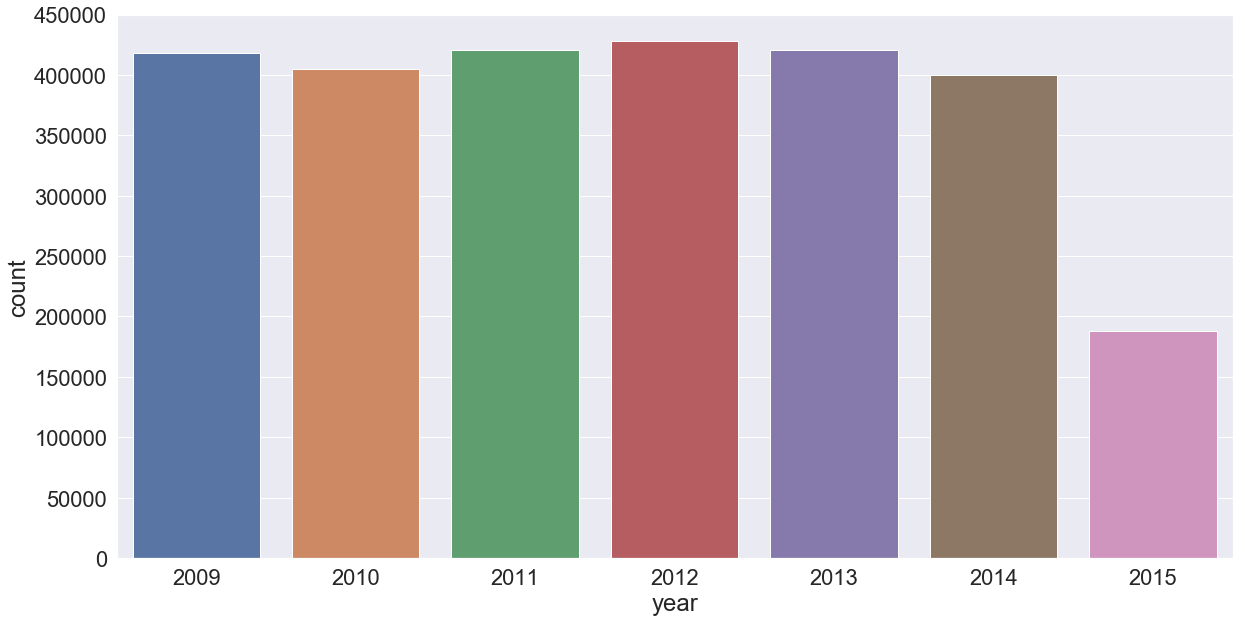

In [22]:
plt.figure(figsize=(20, 10))
n_freq=taxi_train_data['year'].value_counts()
n_freq

n_year = pd.DataFrame({'year':n_freq.index ,'count':n_freq.values})
n_year

sns.set(font_scale =2)

sns.barplot(x='year', y='count', data=n_year, label= "medium")


In [23]:
# this function will also be used with the test set below
def select_within_boundingbox(df, BB):
    return (taxi_train_data.pickup_longitude >= BB[0]) & (taxi_train_data.pickup_longitude <= BB[1]) & \
           (taxi_train_data.pickup_latitude >= BB[2]) & (taxi_train_data.pickup_latitude <= BB[3]) & \
           (taxi_train_data.dropoff_longitude >= BB[0]) & (taxi_train_data.dropoff_longitude <= BB[1]) & \
           (taxi_train_data.dropoff_latitude >= BB[2]) & (taxi_train_data.dropoff_latitude <= BB[3])
            
# load image of NYC map
BB = (-74.5, -72.8, 40.5, 41.8)
nyc_map = plt.imread('https://aiblog.nl/download/nyc_-74.5_-72.8_40.5_41.8.png')

# load extra image to zoom in on NYC
BB_zoom = (-74.3, -73.7, 40.5, 40.9)
nyc_map_zoom = plt.imread('https://aiblog.nl/download/nyc_-74.3_-73.7_40.5_40.9.png')

In [24]:
# this function will be used more often to plot data on the NYC map
def plot_on_map(df, BB, nyc_map, s=10, alpha=0.2):
    fig, axs = plt.subplots(1, 2, figsize=(16,10))
    axs[0].scatter(taxi_train_data.pickup_longitude, taxi_train_data.pickup_latitude, zorder=1, alpha=alpha, c='y', s=s)
    axs[0].set_xlim((BB[0], BB[1]))
    axs[0].set_ylim((BB[2], BB[3]))
    axs[0].set_title('Pickup locations')
    axs[0].imshow(nyc_map, zorder=0, extent=BB)

    axs[1].scatter(taxi_train_data.dropoff_longitude, taxi_train_data.dropoff_latitude, zorder=1, alpha=alpha, c='r', s=s)
    axs[1].set_xlim((BB[0], BB[1]))
    axs[1].set_ylim((BB[2], BB[3]))
    axs[1].set_title('Dropoff locations')
    axs[1].imshow(nyc_map, zorder=0, extent=BB)

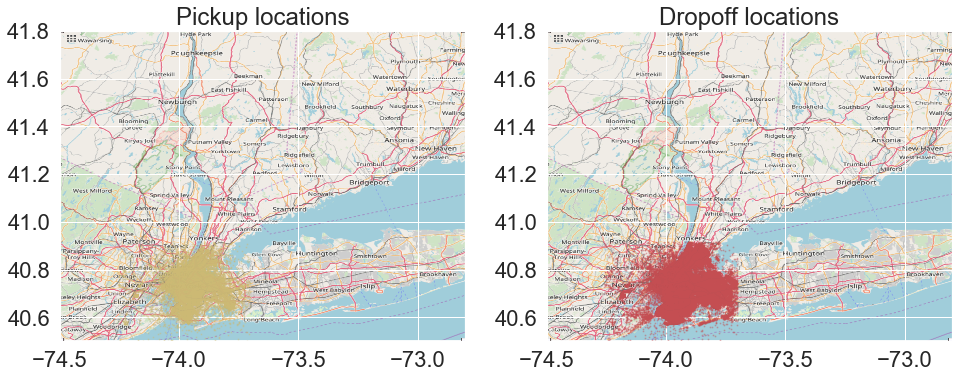

In [25]:
plot_on_map(taxi_train_data, BB, nyc_map, s=1, alpha=0.3)

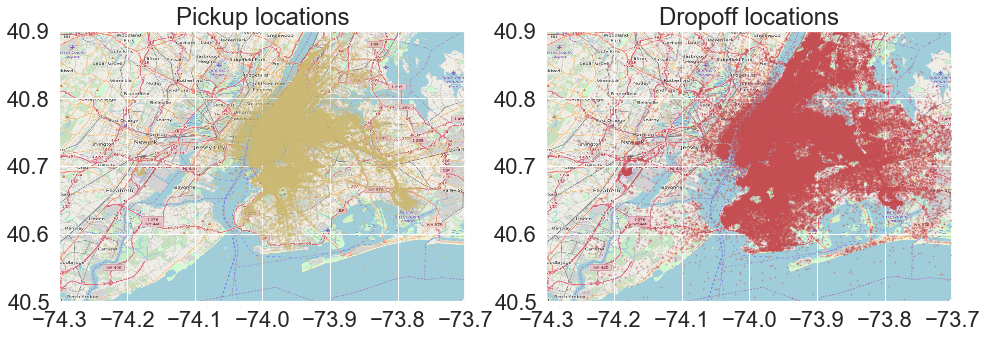

In [26]:
# plot training data on map zoomed in
plot_on_map(taxi_train_data, BB_zoom, nyc_map_zoom, s=1, alpha=0.3)

In [27]:
def plot_hires(taxi_train_data, BB, figsize=(12, 12), ax=None, c=('r', 'b')):
    if ax == None:
        fig, ax = plt.subplots(1, 1, figsize=figsize)

    idx = select_within_boundingbox(taxi_train_data, BB)
    ax.scatter(taxi_train_data[idx].pickup_longitude, taxi_train_data[idx].pickup_latitude, c=c[0], s=0.01, alpha=0.5)
    ax.scatter(taxi_train_data[idx].dropoff_longitude, taxi_train_data[idx].dropoff_latitude, c=c[1], s=0.01, alpha=0.5)

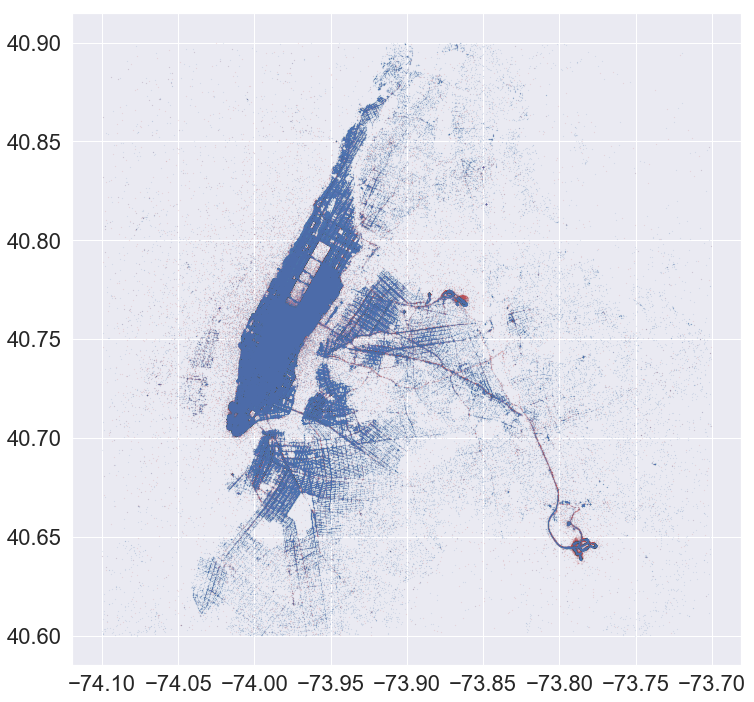

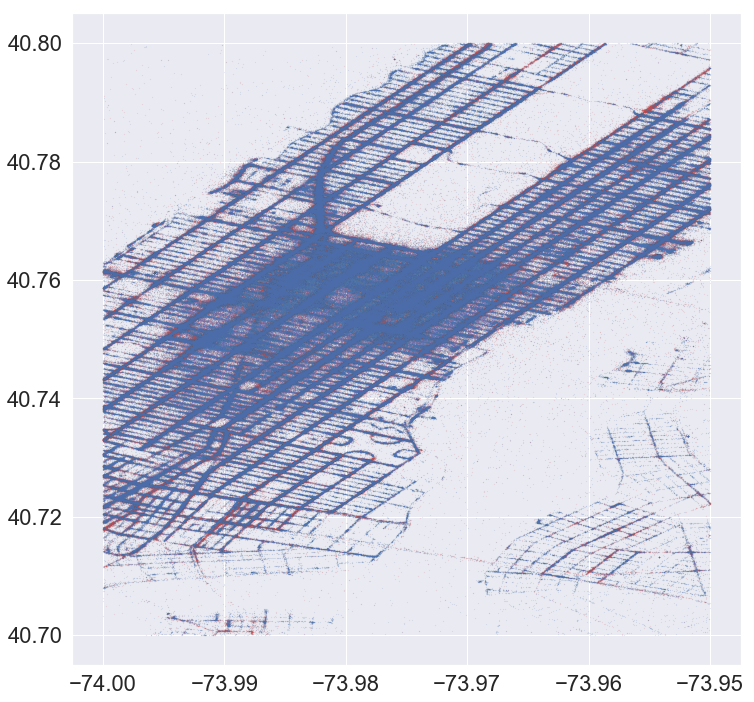

In [28]:
plot_hires(taxi_train_data, (-74.1, -73.7, 40.6, 40.9))
plot_hires(taxi_train_data, (-74, -73.95, 40.7, 40.8))

In [29]:
taxi_train_data.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,hour,weekday,latdiff,londiff,distance_traveled
0,4.500,-73.844,40.721,-73.842,40.712,1,2009,6,15,17,0,0.009,-0.003,0.009
1,16.900,-74.016,40.711,-73.979,40.782,1,2010,1,5,16,1,-0.071,-0.037,0.080
2,5.700,-73.983,40.761,-73.991,40.751,2,2011,8,18,0,3,0.011,0.009,0.014
3,7.700,-73.987,40.733,-73.992,40.758,1,2012,4,21,4,5,-0.025,0.004,0.025
4,5.300,-73.968,40.768,-73.957,40.784,1,2010,3,9,7,1,-0.016,-0.011,0.019


In [30]:
dayOfWeek={0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}
taxi_train_data['weekday'] = taxi_train_data['weekday'].map(dayOfWeek)

In [31]:
taxi_train_data = taxi_train_data.drop( ['latdiff','londiff', 'weekday'], axis=1)

In [32]:
taxi_train_data.head(5)

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,hour,distance_traveled
0,4.500,-73.844,40.721,-73.842,40.712,1,2009,6,15,17,0.009
1,16.900,-74.016,40.711,-73.979,40.782,1,2010,1,5,16,0.080
2,5.700,-73.983,40.761,-73.991,40.751,2,2011,8,18,0,0.014
3,7.700,-73.987,40.733,-73.992,40.758,1,2012,4,21,4,0.025
4,5.300,-73.968,40.768,-73.957,40.784,1,2010,3,9,7,0.019


# Supervised Modeling on Entire Dataset

In [33]:
y_train = taxi_train_data['fare_amount']
X_train = taxi_train_data.drop('fare_amount', axis=1)

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, random_state=42, test_size=0.30)

### Setting a Baseline 

In [90]:
avg_fare=round(np.mean(y_train),2) 
baseline_pred=np.repeat(avg_fare,y_test.shape[0])
baseline_rmse=np.sqrt(mean_squared_error(baseline_pred, y_test))
print("Baseline RMSE of Validation data :",baseline_rmse)

Baseline RMSE of Validation data : 9.3308818121185


I marked "fare_amount" as our target variable and the rest as the dependent variables. Using RMSE to validate our models I achieved a score of $9.33. The models we use below will be used to validate our values

## Linear Regression

In [36]:
from sklearn import linear_model
# Instantiate and fit our model.# Instan 
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X_train, y_train))


Coefficients: 
 [ 9.45249903e+00  6.33672677e+00 -7.12859518e+00 -1.57157757e+01
  2.69587618e-02  4.96860384e-01  6.88159562e-02  9.62680144e-04
  1.06684088e-02  2.13389220e+02]

Intercept: 
 -442.0098878148619

R-squared:
0.7932961788690269


Predict on Test set

In [37]:
y_pred_regr=np.round(regr.predict(X_test),2)
regr_rmse=np.sqrt(mean_squared_error(y_pred_regr, y_test))
print("RMSE for Linear Regression is ",regr_rmse)

RMSE for Linear Regression is  4.239435112843192


In [83]:
y_pred_regr_train =np.round(regr.predict(X_train),2)
regr_train_rmse=np.sqrt(mean_squared_error(regr.predict(X_train), y_train))
print("RMSE for Linear Regression train is ",regr_train_rmse)

RMSE for Linear Regression train is  4.233199599943134


In [84]:
print("Linear Regression Variance is:",  regr_train_rmse-regr_rmse)

Linear Regression Variance is: -0.006235512900057749


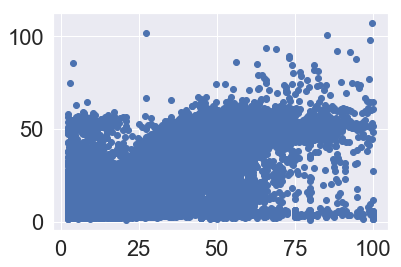

In [38]:
plt.scatter(y_test, y_pred_regr)
#plt.plot(y_train_5, X_train_5, color='red')
#sns.regplot(data_reduced['2005'],data_reduced['2015'])
plt.show()

In [40]:
errors_regr = abs(y_pred_regr - y_test)
print('Mean Absolute Error:', round(np.mean(errors_regr), 2), 'degrees.')


Mean Absolute Error: 2.2 degrees.


In [41]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors_regr / y_test)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 78.53 %.


## Huber Regression

In [42]:
from sklearn.linear_model import HuberRegressor
hr = HuberRegressor()

hr.fit(X_train, y_train)
print('coefficients: ' + str(hr.coef_))
print('intercept: ' + str(hr.intercept_))
print('score: ' + str(hr.score(X_train, y_train)))

coefficients: [ 0.27597586 -0.15419779  0.28589127 -0.15733616 -0.06832247  0.03134808
  0.05016465  0.00047372 -0.00957992  0.41516803]
intercept: -0.0023863799113971527
score: -0.05803273309187396


In [43]:
y_pred=np.round(hr.predict(X_test),2)
hr_rmse=np.sqrt(mean_squared_error(y_pred, y_test))
print("RMSE for Huber Regression is ",hr_rmse)

RMSE for Huber Regression is  9.600402745962626


In [44]:
Y_pred = hr.predict(X_test)

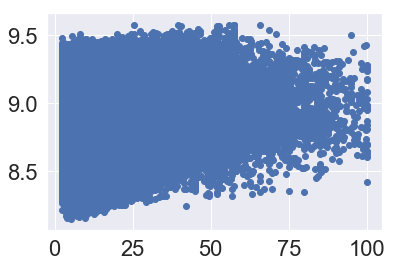

In [45]:
plt.scatter(y_test, Y_pred)
#plt.plot(y_train_5, X_train_5, color='red')
#sns.regplot(data_reduced['2005'],data_reduced['2015'])
plt.show()

## Gradient Boosting

In [46]:


import time

start_time = time.time()
# We'll make 500 iterations, use 2-deep trees, and set our loss function.
params = {'n_estimators': 500,
          'random_state': 42,
          'max_depth': 2,
          'loss': 'huber'}


# Initialize and fit the model.
clf = ensemble.GradientBoostingRegressor(**params)
clf.fit(X_train, y_train)


clf_pred_train= clf.predict(X_train)
clf_rmse_train=np.sqrt(mean_squared_error(clf_pred_train, y_train))
print("RMSE for Gradient Boosting train is ",clf_rmse_train)

print("---Gradient Boosting Regressor %s seconds ---" % (time.time() - start_time))


RMSE for Gradient Boosting train is  3.7043333239724756
---Gradient Boosting Regressor 1520.4747622013092 seconds ---


In [47]:
clf_pred_test= clf.predict(X_test)
clf_rmse_test=np.sqrt(mean_squared_error(clf_pred_test, y_test))
print("RMSE for Gradient Boosting test is ",clf_rmse_test)

RMSE for Gradient Boosting test is  3.714066893408957


In [85]:
print("Gradient Boosting Variance is:",  clf_rmse_train-clf_rmse_test)

Gradient Boosting Variance is: -0.009733569436481293


In [91]:
errors_gb = abs(clf_pred_test - y_test)
print('Mean Absolute Error:', round(np.mean(errors_gb), 2), 'dollars.')

Mean Absolute Error: 1.81 dollars.


In [49]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors_gb / y_test)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 82.76 %.


In [50]:
GB_feature_importances = pd.DataFrame(clf.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)

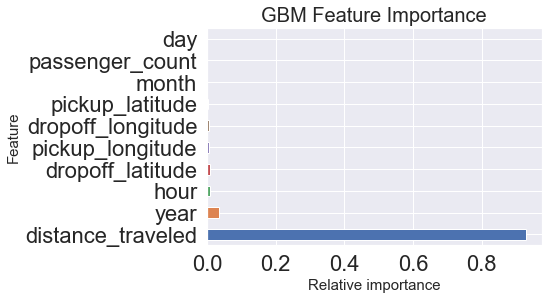

In [51]:
GB_feature_graph = GB_feature_importances['importance'].nlargest(10)
plt.xlabel('Relative importance', fontsize=15)
plt.ylabel('Feature', fontsize=15)
plt.title("GBM Feature Importance", fontsize=20)
GB_feature_graph.plot.barh()

In [52]:
X_train.head(5)

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,hour,distance_traveled
1045136,-73.976,40.752,-73.975,40.742,1,2013,10,26,7,0.011
342264,-73.993,40.748,-74.006,40.731,2,2011,9,16,19,0.021
2138657,-73.981,40.748,-73.989,40.737,2,2009,11,14,12,0.014
1480376,-73.951,40.810,-73.956,40.818,1,2012,1,28,21,0.008
1570444,-73.975,40.760,-73.993,40.768,1,2011,9,23,23,0.019


## Random Forest Regresor

In [73]:
import time
rfr = ensemble.RandomForestRegressor()
rfr.fit(X_train,y_train)

print("---Random Forest Regressor %s seconds ---" % (time.time() - start_time))

rfr_pred_train= rfr.predict(X_train)
rfr_rmse_train=np.sqrt(mean_squared_error(rfr_pred_train, y_train))
print("RMSE for Random Forest Regressor train is ",rfr_rmse_train)


c:\users\david\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


---Random Forest Regressor 7661.930705070496 seconds ---
RMSE for Random Forest Regressor train is  1.4947998731893195


In [55]:


rfr_pred_test= rfr.predict(X_test)
rfr_rmse_test=np.sqrt(mean_squared_error(rfr_pred_test, y_test))
print("RMSE for Random Forest Regressor test is ",rfr_rmse_test)

RMSE for Random Forest Regressor test is  3.521688435049691


In [88]:
print("Random Forest Regressor Variance is:",  rfr_rmse_train-rfr_rmse_test)

Random Forest Regressor Variance is: -2.0268885618603716


In [57]:
errors_rfr = abs(rfr_pred_test - y_test)
print('Mean Absolute Error:', round(np.mean(errors_rfr), 2), 'degrees.')


Mean Absolute Error: 1.77 degrees.


In [58]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors_rfr / y_test)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 81.17 %.


## XGBoost

In [69]:
import xgboost as xgb
def XGBmodel(X_train,X_test,y_train,y_test):
    matrix_train = xgb.DMatrix(X_train,label=y_train)
    matrix_test = xgb.DMatrix(X_test,label=y_test)
    model=xgb.train(params={'objective':'reg:linear','eval_metric':'rmse',
                            'eta':.3,
                            'max_depth':4,
                            'min_child_weight':3,
                           }
                    ,dtrain=matrix_train,num_boost_round=300,
                    early_stopping_rounds=10,evals=[(matrix_test,'test')],)
    return model


In [70]:
model=XGBmodel(X_train,X_test,y_train,y_test)

[21:37:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[0]	test-rmse:10.4129
Will train until test-rmse hasn't improved in 10 rounds.
[21:37:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[1]	test-rmse:7.84166
[21:37:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[2]	test-rmse:6.17487
[21:37:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[3]	test-rmse:5.13068
[21:37:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[4]	test-rmse:4.51494
[21:37:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74

[46]	test-rmse:3.49737
[21:38:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[47]	test-rmse:3.49473
[21:38:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[48]	test-rmse:3.49305
[21:38:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[49]	test-rmse:3.49063
[21:38:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[50]	test-rmse:3.48973
[21:39:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[51]	test-rmse:3.48908
[21:39:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 

[21:40:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[94]	test-rmse:3.43322
[21:40:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[95]	test-rmse:3.43231
[21:40:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[96]	test-rmse:3.43002
[21:40:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[97]	test-rmse:3.42753
[21:40:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[98]	test-rmse:3.42731
[21:40:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 prune

[21:41:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=4
[141]	test-rmse:3.40263
[21:41:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[142]	test-rmse:3.40245
[21:41:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[143]	test-rmse:3.40285
[21:42:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[144]	test-rmse:3.40281
[21:42:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=4
[145]	test-rmse:3.40273
[21:42:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 

[187]	test-rmse:3.38614
[21:43:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=4
[188]	test-rmse:3.38599
[21:43:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[189]	test-rmse:3.38548
[21:43:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[190]	test-rmse:3.38511
[21:43:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[191]	test-rmse:3.38332
[21:43:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[192]	test-rmse:3.3826
[21:43:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 ro

[234]	test-rmse:3.37019
[21:44:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 0 pruned nodes, max_depth=4
[235]	test-rmse:3.3701
[21:44:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[236]	test-rmse:3.37008
[21:44:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[237]	test-rmse:3.37008
[21:44:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[238]	test-rmse:3.37012
[21:45:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=4
[239]	test-rmse:3.3702
[21:45:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roo

[281]	test-rmse:3.35996
[21:46:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=4
[282]	test-rmse:3.35955
[21:46:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[283]	test-rmse:3.35956
[21:46:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=4
[284]	test-rmse:3.3596
[21:46:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=4
[285]	test-rmse:3.35955
[21:46:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=4
[286]	test-rmse:3.35966
[21:46:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 ro

In [71]:
matrix_train = xgb.DMatrix(X_train,label=y_train)
matrix_test = xgb.DMatrix(X_test,label=y_test)

In [76]:
xgb_pred_train= model.predict(matrix_train)
xgb_rmse_train=np.sqrt(mean_squared_error(xgb_pred_train, y_train))
print("RMSE for XGBOOST is ",xgb_rmse_train)

RMSE for XGBOOST is  3.2736419921926423


In [80]:
xgb_pred_test=model.predict(matrix_test)
xgb_rmse_test=np.sqrt(mean_squared_error(xgb_pred_test, y_test))
print("RMSE for XGBOOST is ",xgb_rmse_test)

RMSE for XGBOOST is  3.3577651234477286


In [89]:
print("XGBoost Variance is:",  xgb_rmse_train-xgb_rmse_test)

XGBoost Variance is: -0.0841231312550863


In [81]:
errors_xgb = abs(xgb_pred_test - y_test)
print('Mean Absolute Error:', round(np.mean(errors_xgb), 2), 'degrees.')

Mean Absolute Error: 1.69 degrees.


In [82]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors_xgb / y_test)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 82.19 %.


## Conclusions 